In [65]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras import optimizers

from sklearn.metrics import accuracy_score

import warnings 
warnings.filterwarnings('ignore')

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\90530\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [66]:
data = pd.read_csv('IMDB Dataset.csv')

df = data.copy()

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [67]:
df.shape

(50000, 2)

<Axes: >

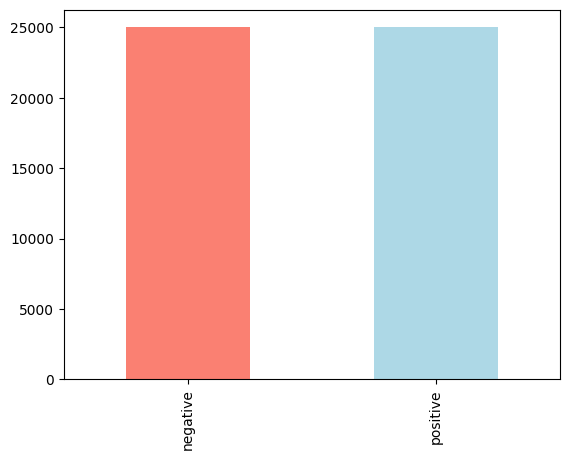

In [68]:
df['sentiment'].value_counts().sort_index().plot(kind='bar', color=['salmon', 'lightblue'])

### Sample Preprocessing

In [69]:
sample = df['review'][1]
sample

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [70]:
sample = BeautifulSoup(sample).get_text()
sample

'A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well done.'

In [71]:
sample = re.sub('[^a-zA-Z]', ' ', sample)
sample

'A wonderful little production  The filming technique is very unassuming  very old time BBC fashion and gives a comforting  and sometimes discomforting  sense of realism to the entire piece  The actors are extremely well chosen  Michael Sheen not only  has got all the polari  but he has all the voices down pat too  You can truly see the seamless editing guided by the references to Williams  diary entries  not only is it well worth the watching but it is a terrificly written and performed piece  A masterful production about one of the great master s of comedy and his life  The realism really comes home with the little things  the fantasy of the guard which  rather than use the traditional  dream  techniques remains solid then disappears  It plays on our knowledge and our senses  particularly with the scenes concerning Orton and Halliwell and the sets  particularly of their flat with Halliwell s murals decorating every surface  are terribly well done '

In [72]:
sample = sample.lower()
sample

'a wonderful little production  the filming technique is very unassuming  very old time bbc fashion and gives a comforting  and sometimes discomforting  sense of realism to the entire piece  the actors are extremely well chosen  michael sheen not only  has got all the polari  but he has all the voices down pat too  you can truly see the seamless editing guided by the references to williams  diary entries  not only is it well worth the watching but it is a terrificly written and performed piece  a masterful production about one of the great master s of comedy and his life  the realism really comes home with the little things  the fantasy of the guard which  rather than use the traditional  dream  techniques remains solid then disappears  it plays on our knowledge and our senses  particularly with the scenes concerning orton and halliwell and the sets  particularly of their flat with halliwell s murals decorating every surface  are terribly well done '

In [73]:
eng_stopwords = stopwords.words('english')
eng_stopwords[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [74]:
sample = [word for word in sample.split() if word not in eng_stopwords]
sample[0:10]

['wonderful',
 'little',
 'production',
 'filming',
 'technique',
 'unassuming',
 'old',
 'time',
 'bbc',
 'fashion']

### Preprocessing

In [75]:
eng_stopwords = stopwords.words('english')

def preprocessing(review):

    review = BeautifulSoup(review).get_text()
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    review = [word for word in review.split() if word not in eng_stopwords]

    return ' '.join(review)

df['review'] = df['review'].apply(preprocessing)

In [76]:
y = df['sentiment']
X = df['review']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

tokenizer = Tokenizer(num_words=5000)

tokenizer.fit_on_texts(X)

X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

In [77]:
num_tokens = np.array([len(token) for token in X_train_token + X_test_token])

print('mean', num_tokens.mean())
print('std', num_tokens.std())
print('argmax', num_tokens.argmax())

mean 96.81746
std 69.8731829756481
argmax 4059


In [78]:
max_token = int(num_tokens.mean() + 2 * num_tokens.std())
max_token

236

In [79]:
X_train_token_pad = pad_sequences(X_train_token, maxlen=max_token)
X_test_token_pad = pad_sequences(X_test_token, maxlen=max_token)

In [80]:
X_train_token_pad.shape, X_test_token_pad.shape, y_train.shape, y_test.shape

((40000, 236), (10000, 236), (40000,), (10000,))

In [81]:
model = Sequential()

model.add(
    Embedding(
        input_dim=5000,
        output_dim=50,
        input_length=max_token
    )
)

model.add(GRU(units=16, activation='tanh', return_sequences=True))
model.add(GRU(units=8, activation='tanh', return_sequences=True))
model.add(GRU(units=4, activation='tanh', return_sequences=False))

model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 236, 50)           250000    
                                                                 
 gru_15 (GRU)                (None, 236, 16)           3264      
                                                                 
 gru_16 (GRU)                (None, 236, 8)            624       
                                                                 
 gru_17 (GRU)                (None, 4)                 168       
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 254061 (992.43 KB)
Trainable params: 254061 (992.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [82]:
y_train = y_train.map({'positive':1, 'negative':0})
y_test = y_test.map({'positive':1, 'negative':0})

In [83]:
model.fit(X_train_token_pad, y_train, epochs=2)

Epoch 1/2
1250/1250 [==============================] - 184s 142ms/step - loss: 0.3616 - accuracy: 0.8409
Epoch 2/2
1250/1250 [==============================] - 180s 144ms/step - loss: 0.2458 - accuracy: 0.9051


In [85]:
model.evaluate(X_test_token_pad, y_test)[1]

313/313 [==============================] - 15s 42ms/step - loss: 0.2802 - accuracy: 0.8842


0.8841999769210815

In [87]:
predicted = model.predict(X_test_token_pad)

313/313 [==============================] - 13s 38ms/step


In [89]:
y_pred = [1 if pred >=0.5 else 0 for pred in predicted]

In [91]:
accuracy_score(y_test, y_pred)

0.8842